In [133]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter
import re
import textwrap
import bitsandbytes
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from transformers.utils import logging
import warnings
from upsetplot import from_contents, UpSet
import seaborn as sns
logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=FutureWarning)

In [61]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.6 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 4.3 MB/s eta 0:00:03
     --------- ------------------------------ 3.1/12.8 MB 4.3 MB/s eta 0:00:03
     ------------- -------------------------- 4.2/12.8 MB 4.4 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 4.4 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 4.5 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.6 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 4.4 MB/s eta 0:00:02
     -------------------------- ------------- 8.4/12.8 MB 4.1 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 4.0 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 3.8 MB/s

2025-07-08 10:35:18.968407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Graphs plotting functions

In [62]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 

    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]

    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_grouped_bar_chart(indices, group1, group2, title, xlabel, ylabel):
    width = 0.35
    x = np.arange(len(indices))

    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, group1, width, label='Group 1', color='cornflowerblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, group2, width, label='Group 2', color='lightcoral', edgecolor='black')

    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, rotation=90, ha='center', fontsize=10)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=1000,height=500,background_color='white',colormap='viridis',prefer_horizontal=0.9,scale=2,font_step=1).generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=24, fontweight='bold', pad=20)
    plt.tight_layout(pad=5)
    plt.show()

### Combining Author(given by the author) and Index(given by Scopus) keywords into one column, removing some redundant keywords present mostly in the index keywords

In [63]:
def combine_keywords(df):
    author_kws = df['Author Keywords'].fillna('').str.split(';')
    index_kws = df['Index Keywords'].fillna('').str.split(';')

    stop_keywords = {'man', 'woman', 'male', 'follow up', 'female', 'nonhuman', 'surveys', 'young adult', 'human', 'study', 'method', 'algorithms', 'article', 'adult', 'simple++', 'humans', "'current"}
    combined_keywords = []

    for a_kws, i_kws in zip(author_kws, index_kws):
        kws = set()
        if a_kws:
            kws.update([kw.strip().lower() for kw in a_kws if kw])
        if i_kws:
            kws.update([kw.strip().lower() for kw in i_kws if kw])
        kws = {kw for kw in kws if kw not in stop_keywords}
        combined_keywords.append(list(kws))

    return combined_keywords

### 1. Loading the articles data from Scopus: having 500 articles from each year from 2015-2025 - 5500 articles in total

In [64]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df['Combined Keywords'] = combine_keywords(articles_df)
articles_df.head(10)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords,Combined Keywords
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN,"[autoencoder, natural language processing (nlp..."
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...,"[processing model, foundation models, natural ..."
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN,"[natural language processing, deep learning, a..."
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...,"[social aspects, information extraction, legal..."
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...,"[natural languages, application programs, lang..."
5,Zhao X.; Li L.; Wang Y.-X.,"Zhao, Xuandong (57552407600); Li, Lei (5609407...",57552407600; 56094074700; 58912060300,Distillation-Resistant Watermarking for Model ...,2022,Findings of the Association for Computational ...,https://www.scopus.com/inward/record.uri?eid=2...,How can we protect the intellectual property o...,NaN,Classification (of information); Computational...,"[novel techniques, part of speech tagging, dis..."
6,Latha B.; Nivedha B.; Ranjanaa Y.,"Latha, B. (26643194000); Nivedha, B. (57202678...",26643194000; 57202678926; 58127747300,Visual Audio Summarization Based on NLP Models,2022,2022 1st International Conference on Computati...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) uses compute...,Abstractive; comparison; extractive; Natural L...,Visual languages; Abstractive; Audio summariza...,"[extractive, key patterns, processing model, n..."
7,Rajan A.; Salgaonkar A.,"Rajan, Annie (57215688946); Salgaonkar, Ambuja...",57215688946; 35485507600,Survey of NLP Resources in Low-Resource Langua...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Research results in different subdomains of NL...,Konkani language; Natural language processing;...,NaN,"[natural language processing, nepali language,..."
8,Desai N.P.; Dabhi V.K.,"Desai, Nikita P. (26639236000); Dabhi, Vipul K...",26639236000; 24823939300,Resources and components for gujarati NLP syst...,2022,Artificial Intelligence Review,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) represents t...,Components; Corpus; Gujarati; Indian language;...,Digital storage; Fake detection; Surveys; Auto...,"[human language, component,

In [65]:
abstracts = articles_df['Abstract'].dropna().tolist()

### 2. Pre-processing the article's abstracts

In [66]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


['With artificial intelligence permeating conversations and marketing interactions through digital technologies and media, machine learning models, in particular, natural language processing (NLP) models, have surged in popularity for analyzing unstructured data in marketing. Yet, we do not fully understand which NLP models are appropriate for which marketing applications and what insights can be best derived from them. We review different NLP models and their applications in marketing. We layout the advantages and disadvantages of these models and highlight the conditions under which different models are appropriate in the marketing context. We introduce the latest neural autoencoder NLP models, demonstrate these models to analyze new product announcements and news articles, and provide an empirical comparison of the different autoencoder models along with the statistical NLP models. We discuss the insights from the comparison and offer guidelines for researchers. We outline future ex

### 3. Extracting the most common words in abstracts using TF-IDF - those with the highest scores

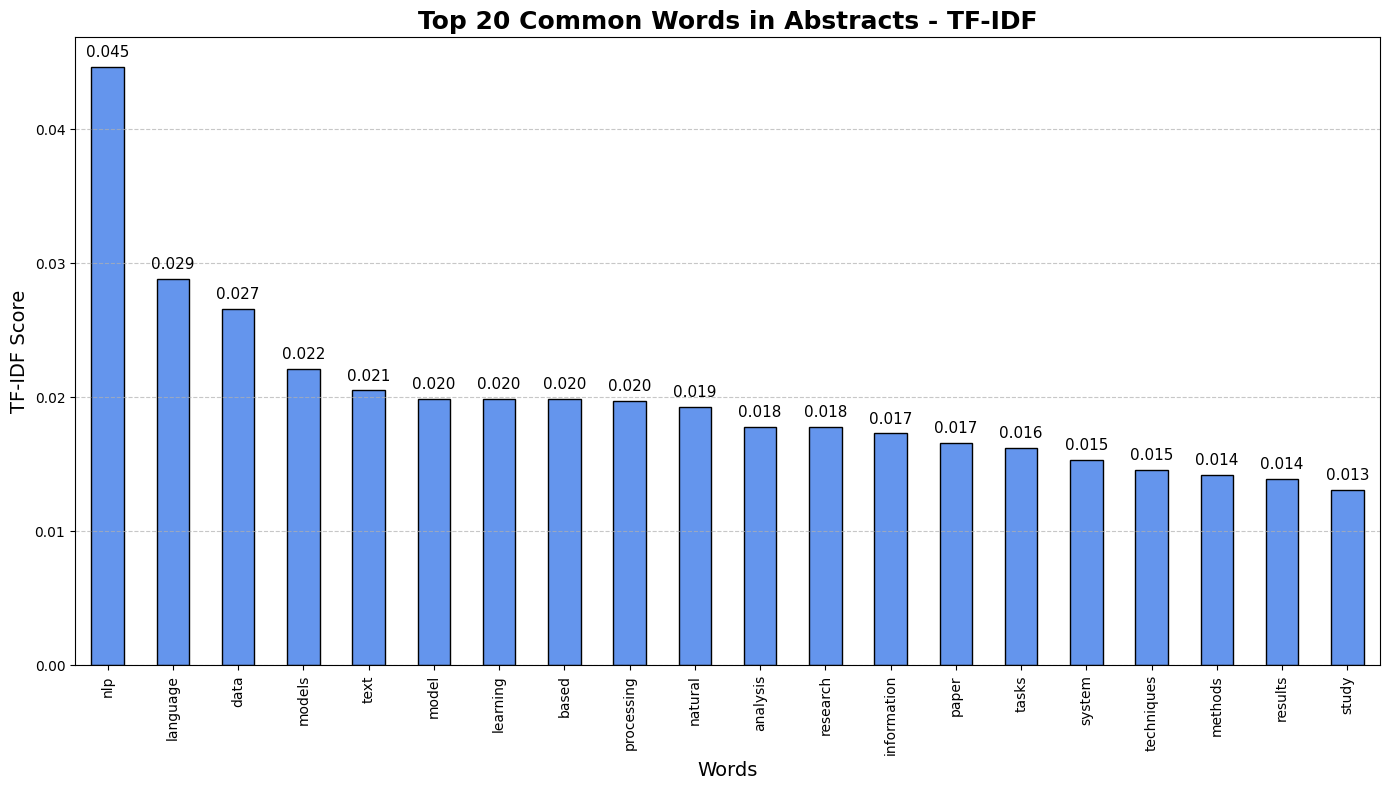

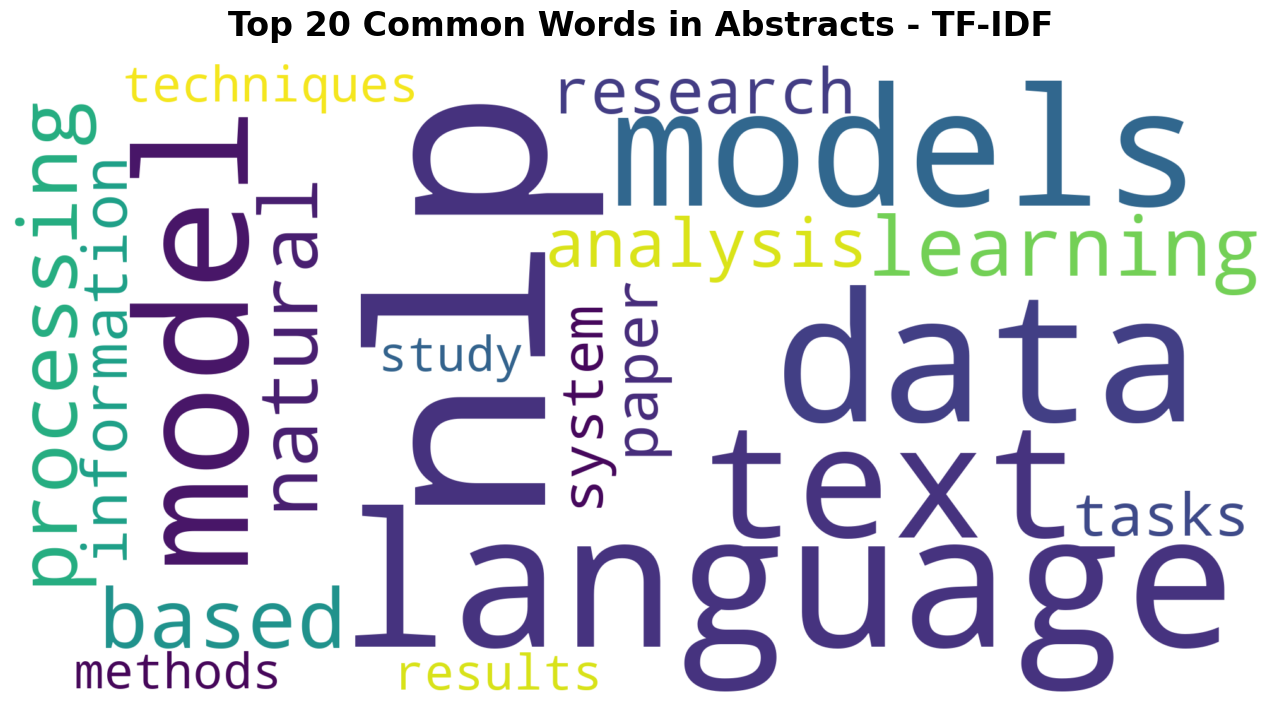

In [67]:
def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
create_bar_chart(pd.Series(top_words_df['score'].values, index=top_words_df['word']), "Top 20 Common Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Common Words in Abstracts - TF-IDF")


### 4. Extracting the most common words in abstracts using Word2Vec.
### High min_count makes sure the words sampled aren't ones that don't appear often and will apply more weight into the averaged vector, the words most close to it are picked

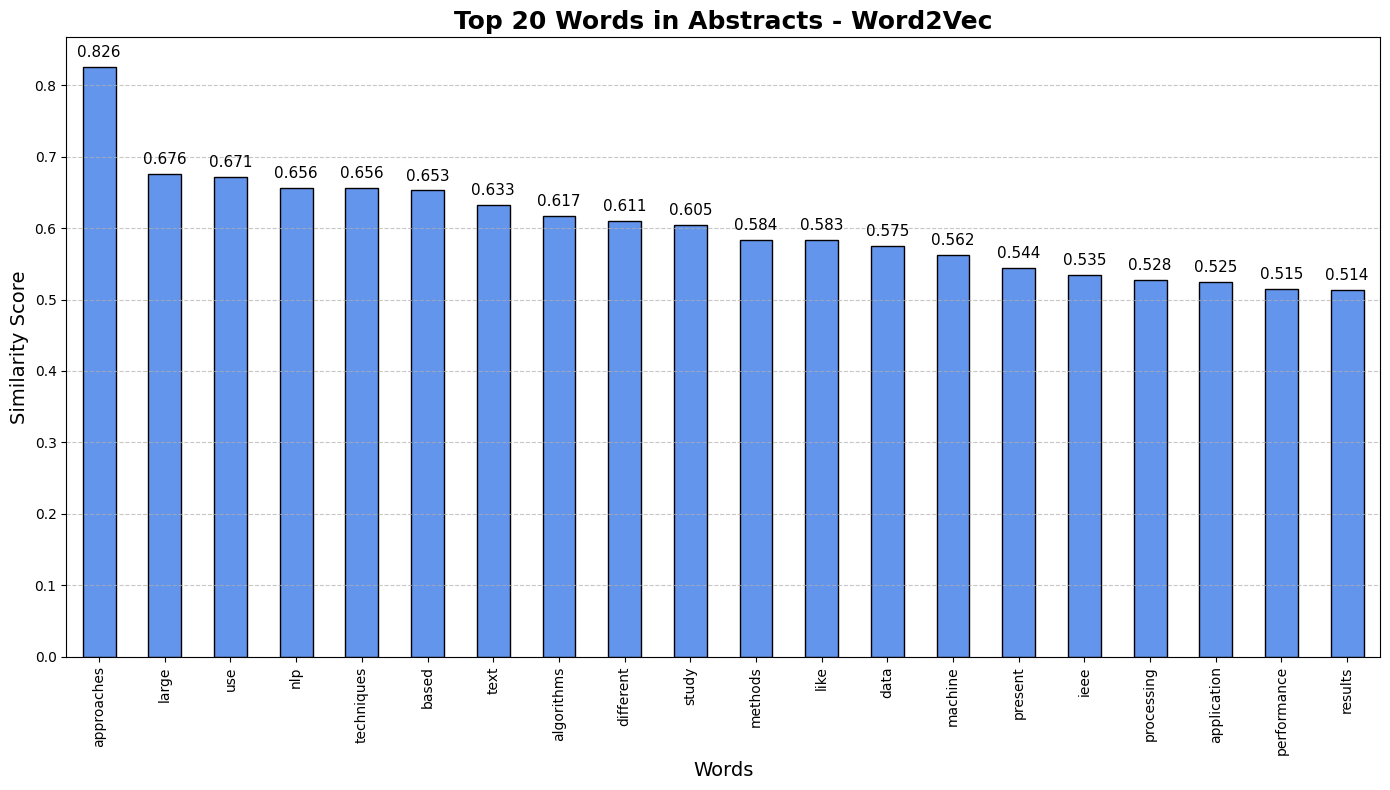

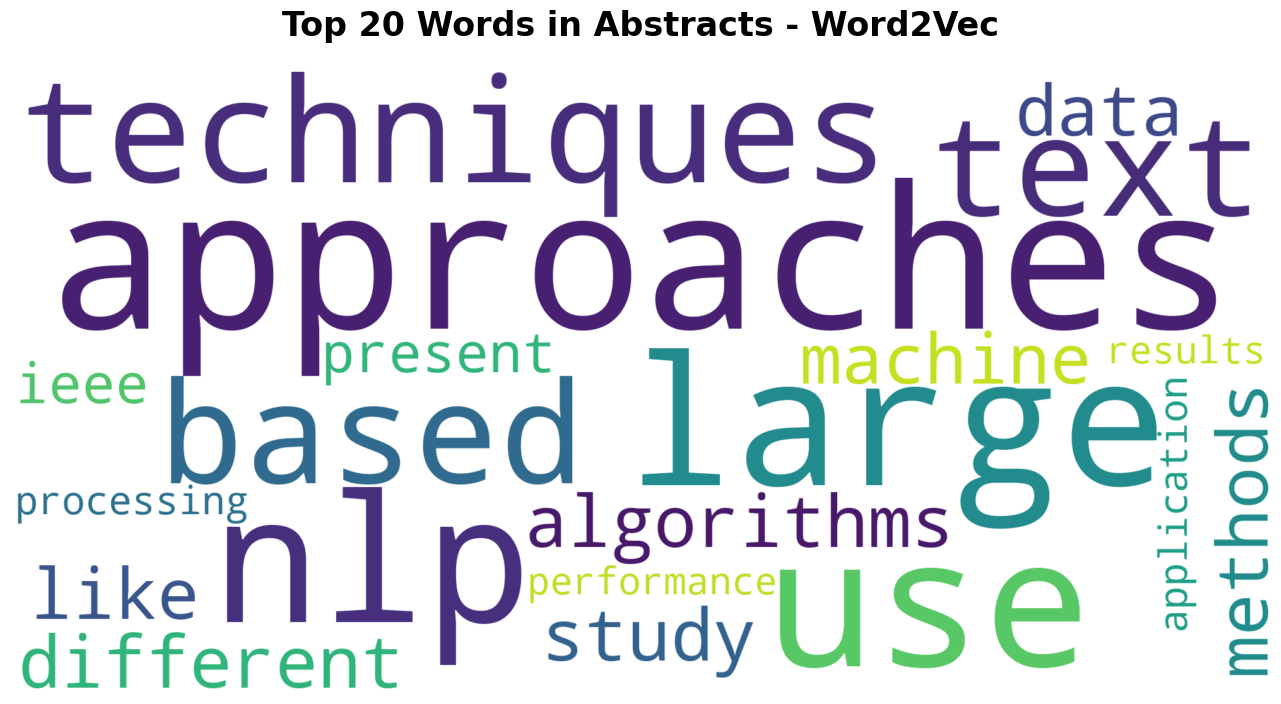

In [84]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=800, workers=1, seed=42)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


### 5. Extracting the most common words in abstracts using AutoEncoder
### I have picked up the words that the decoder had the most trouble reconstructing - thus were harder to compress - thus are more distinct and often important 

378/378 [==============================] - 0s 508us/step
Top 20 words with highest reconstruction error:


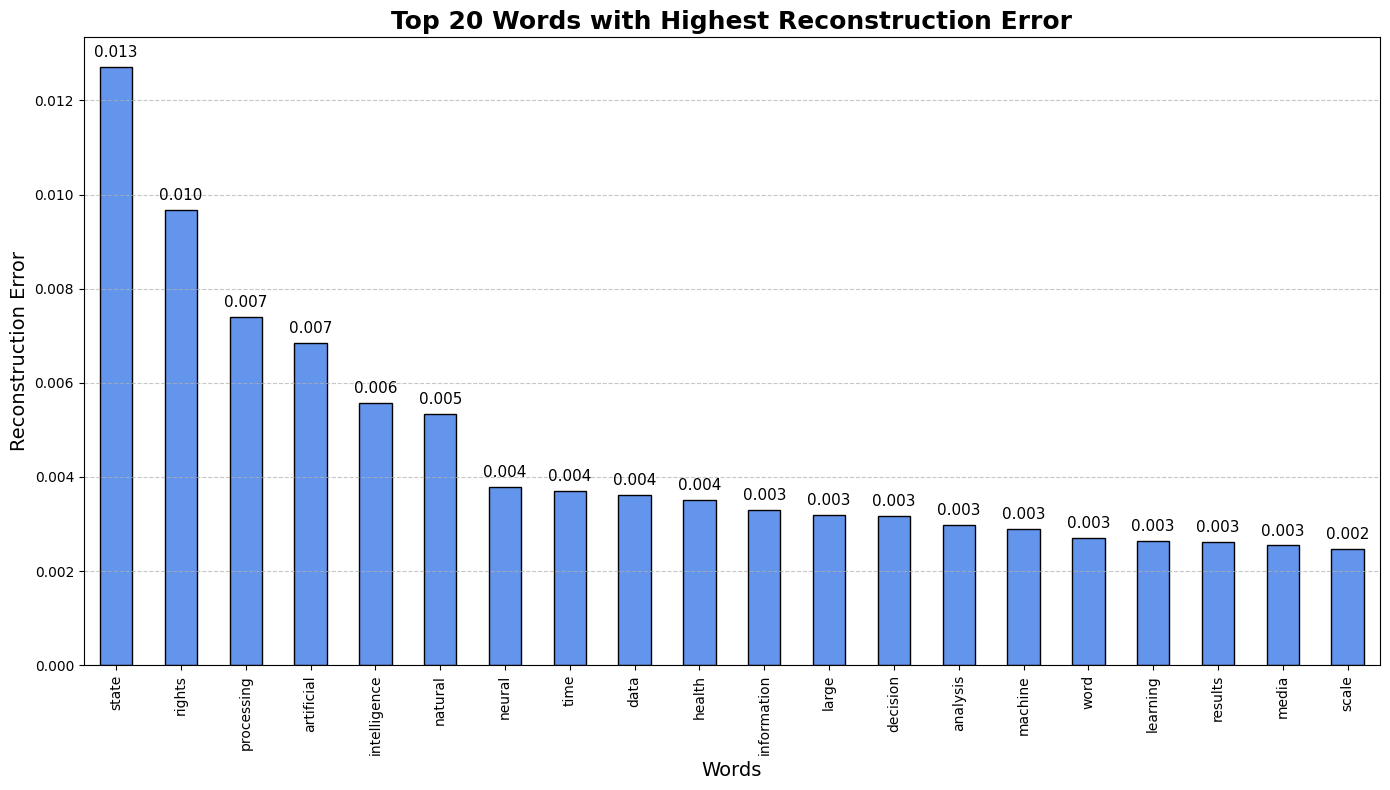

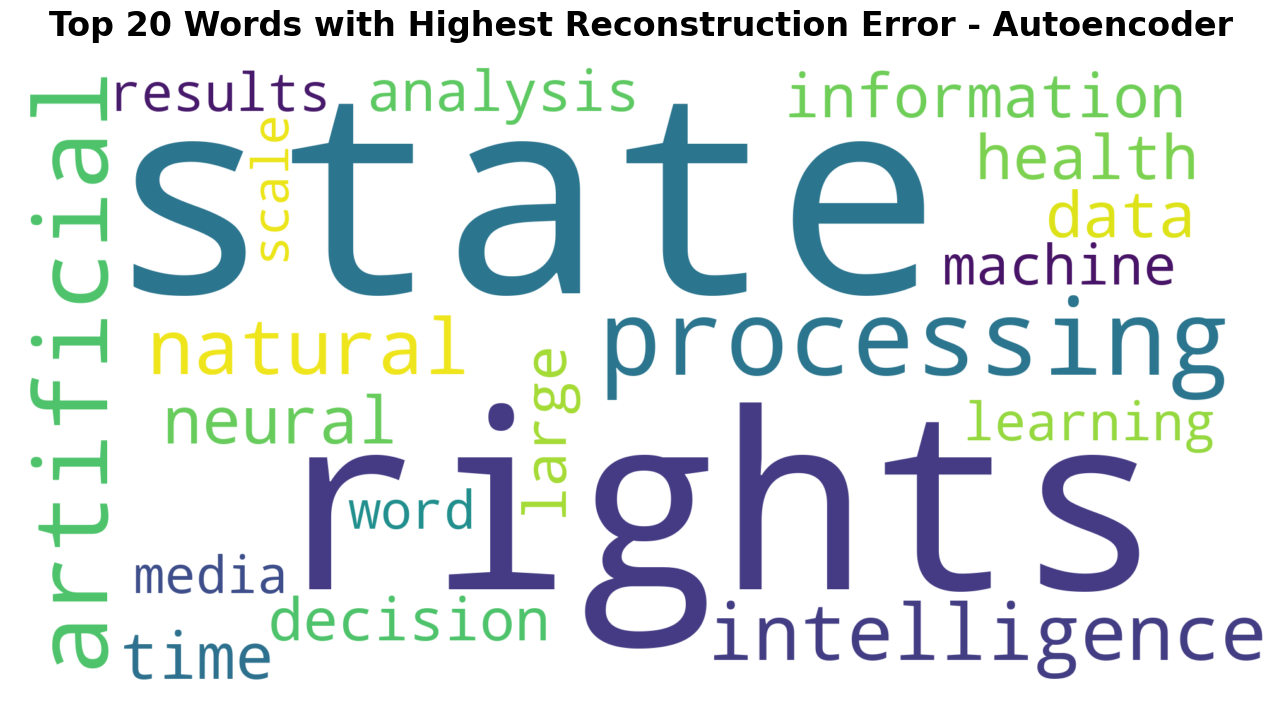

In [81]:
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=3, workers=1, seed=42)
words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)

predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))
word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)
print(f"Top 20 words with highest reconstruction error:")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

### 6. The differences between 3-5
### Showing the intersection between the 3 groups and the actual most common words
### TF-IDF - the most useful for finding common words as they usually get high score.
### Word2Vec - isn't often used for this mission - but making sure encoding words appearing in part of the articles helped
### Autoencoder - found words that hard to compress - thus not necessary common but rather important and unique semantically    

Actual top common words: ['nlp', 'language', 'data', 'processing', 'natural', 'based', 'models', 'text', 'model', 'learning', 'research', 'analysis', 'paper', 'information', 'results', 'methods', 'study', 'system', 'tasks', 'techniques']
Common words in all three methods: {'data', 'processing', 'results'}
Common words in TF-IDF and Word2Vec: {'nlp', 'data', 'methods', 'study', 'results', 'techniques', 'processing', 'based', 'text'}
Common words in TF-IDF and autoencoder: {'data', 'learning', 'natural', 'information', 'results', 'processing', 'analysis'}
Common words in Word2Vec and autoencoder: {'data', 'results', 'machine', 'large', 'processing'}


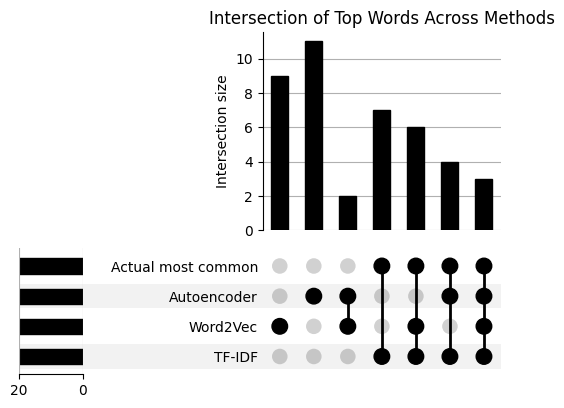

In [ ]:
top_tfidf_words = set(top_words_df['word'])
top_word2vec_words = set(word for word, _ in similar_words)
top_autoencoder_words = set(word for word, _ in word_errors_sorted[:20])
actual_common_words = model.wv.index_to_key[:20]
print(f"Actual top common words: {actual_common_words}")
print(f"Common words in all three methods: {top_tfidf_words.intersection(top_word2vec_words).intersection(top_autoencoder_words)}")
print(f"Common words in TF-IDF and Word2Vec: {top_tfidf_words.intersection(top_word2vec_words)}")
print(f"Common words in TF-IDF and autoencoder: {top_tfidf_words.intersection(top_autoencoder_words)}")
print(f"Common words in Word2Vec and autoencoder: {top_word2vec_words.intersection(top_autoencoder_words)}")

set_dict = {
    'TF-IDF': top_tfidf_words,
    'Word2Vec': top_word2vec_words,
    'Autoencoder': top_autoencoder_words,
    'Actual most common': set(actual_common_words)
}
upset_data = from_contents(set_dict)
UpSet(upset_data, subset_size='count').plot()
plt.title("Intersection of Top Words Across Methods")
plt.show()

### 7. Performing NER

In [71]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

In [ ]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")
for (ent, label), count in entity_counter.most_common(20):
    print(f"{ent} ({label}): {count}")
org_counter = Counter([ent for ent, label in entities if label == "ORG"])
common_orgs = set(org for org, count in org_counter.items() if count >= 20)
print("Common ORGs:", common_orgs)


Top 20 entities seen with their types:
NLP (ORG): 14499
two (CARDINAL): 1047
first (ORDINAL): 637
three (CARDINAL): 620
Natural Language Processing (ORG): 604
AI (ORG): 489
English (LANGUAGE): 464
2015 (DATE): 451
2019 (DATE): 418
BERT (ORG): 416
2017 (DATE): 397
2018 (DATE): 376
2025 (DATE): 371
2021 (DATE): 362
2022 (DATE): 348
2 (CARDINAL): 336
one (CARDINAL): 331
2020 (DATE): 324
ML (ORG): 305
1 (CARDINAL): 303
Common ORGs: {'PPV', 'WSD', 'FL', 'CT', 'BLEU', 'IGI Global', 'NLI', 'NLU', 'IBM', 'the Natural Language Processing', 'CRF', 'ROUGE', 'YouTube', 'ADR', 'IGI Global Scientific Publishing', 'Springer Science+Business Media', '2022 Association for Computational Linguistics', 'Random Forest', 'NLP', 'IR', 'Stanford', 'SA', 'RNN', 'Transformer', 'KNN', 'PDF', 'p < 0.001', 'Naïve Bayes', 'BERT', 'ACM', 'Artificial Intelligence', 'Information Retrieval', 'OCR', 'Machine Translation', 'SQL', 'Springer Nature Singapore Pte Ltd.', 'EMRs', 'Mayo Clinic', 'MTL', 'Association for the Adv

# 8.EDA

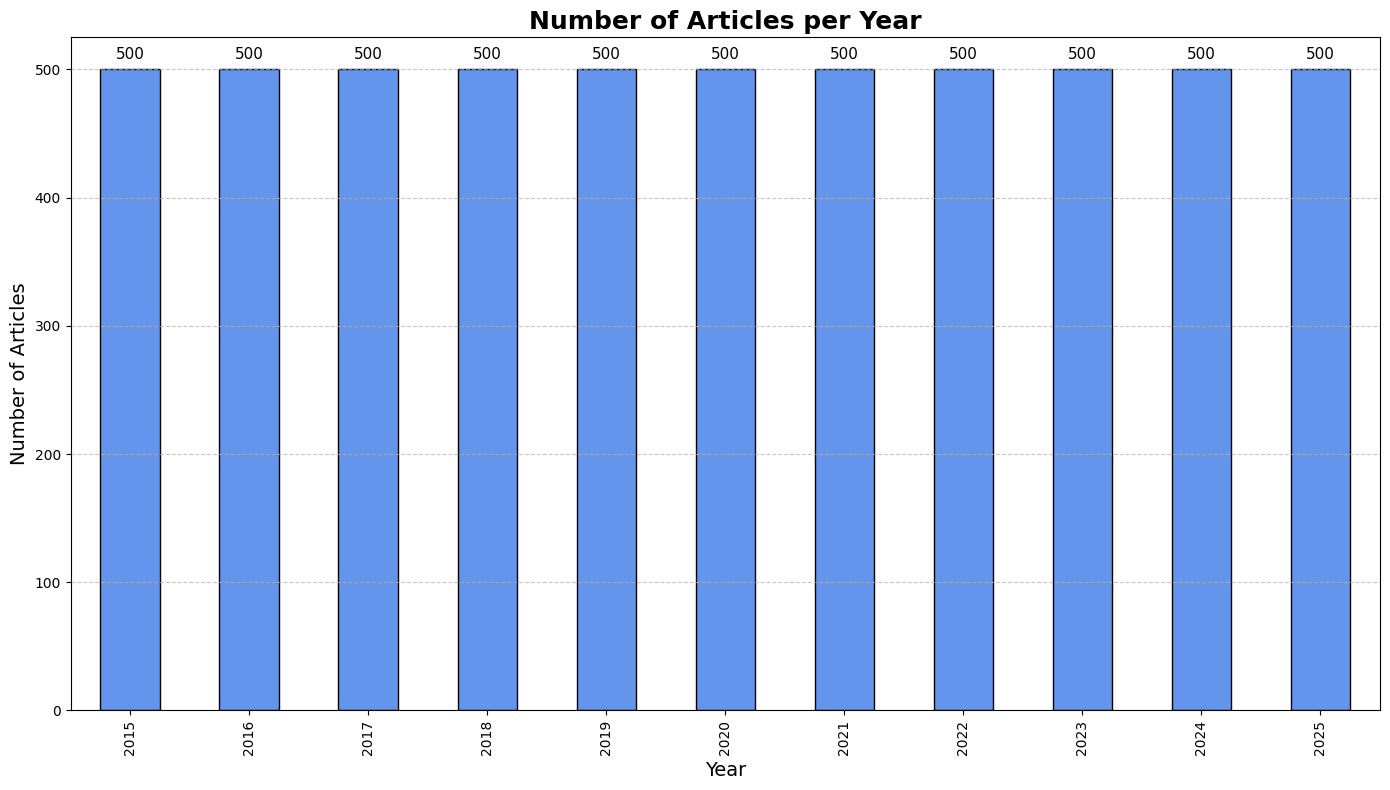

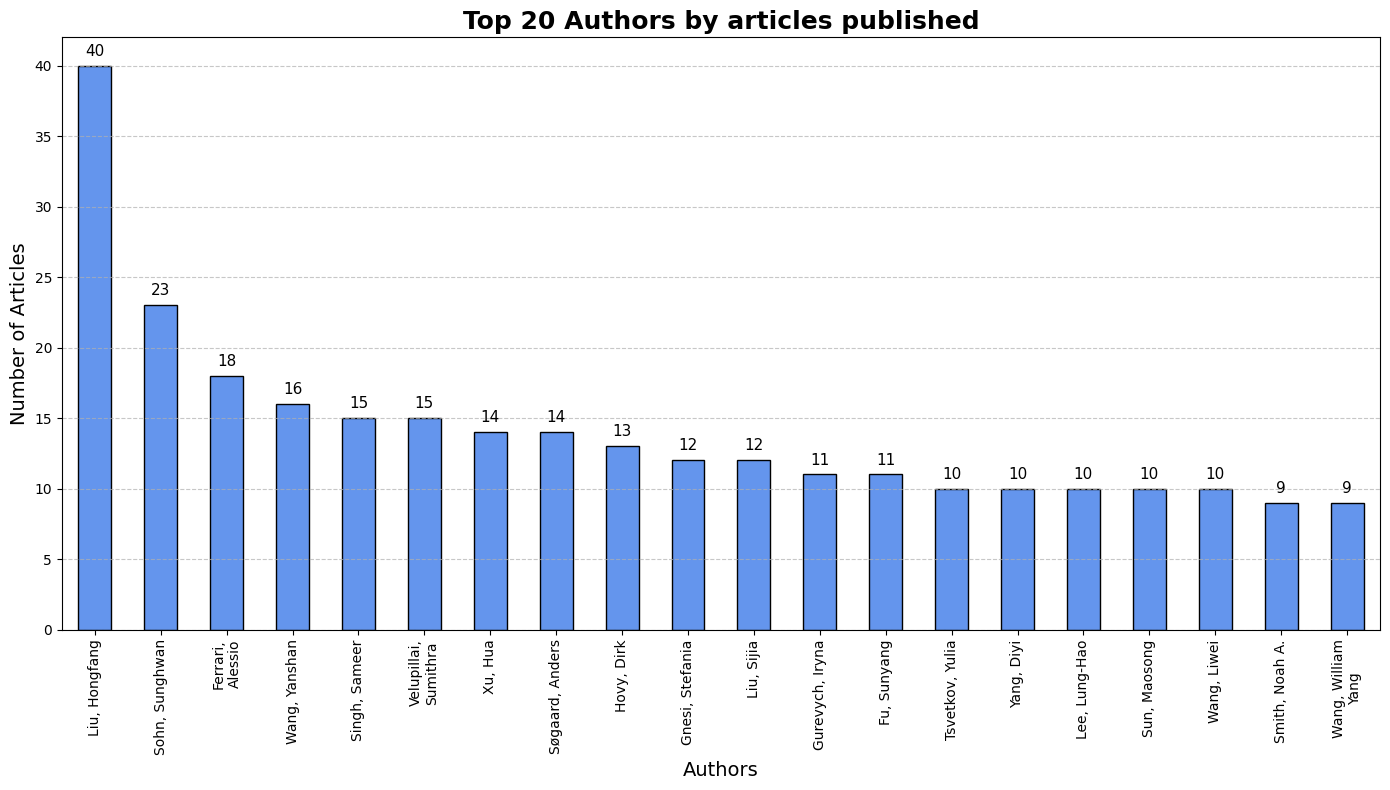

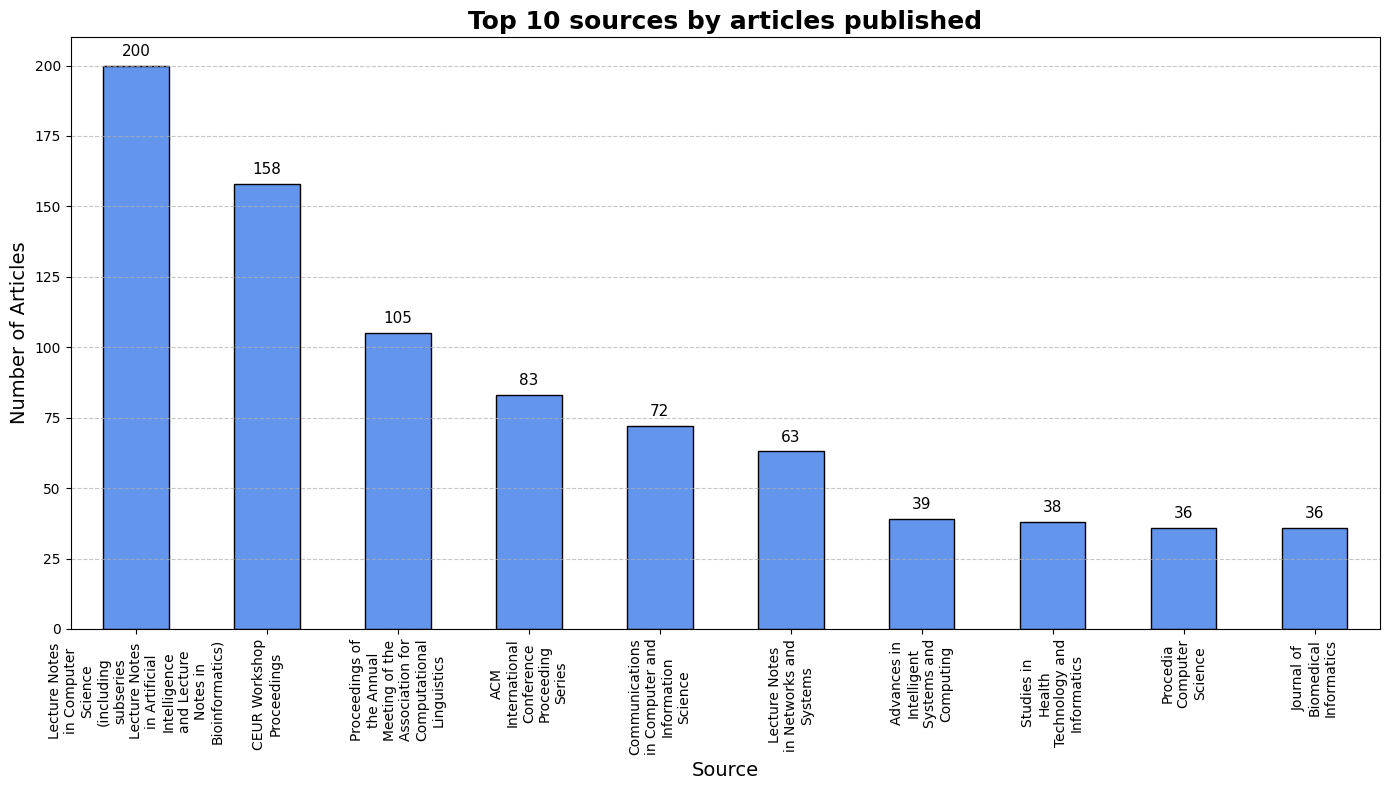

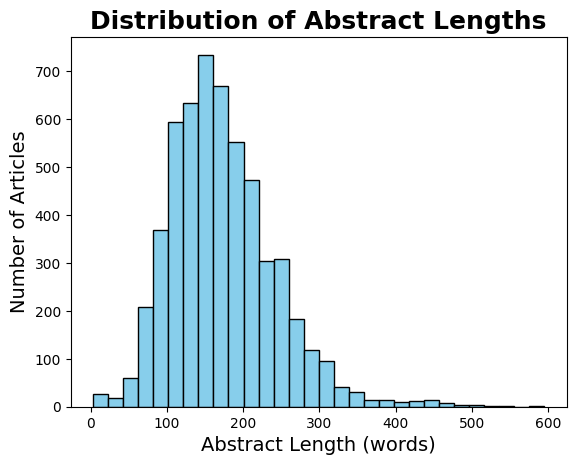

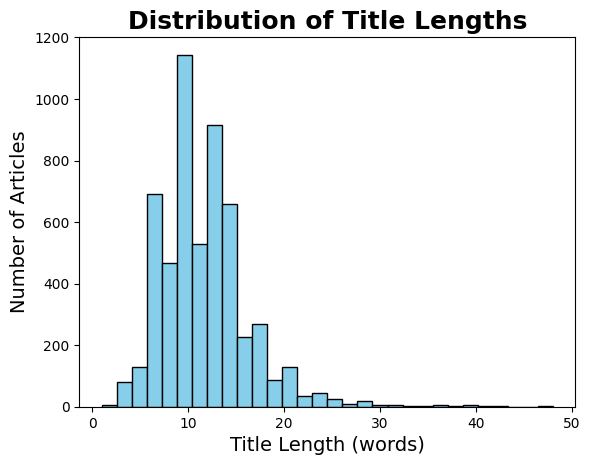

In [ ]:
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(20)
create_bar_chart(top_authors, "Top 20 Authors by articles published", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 sources by articles published", "Source", "Number of Articles")

In [ ]:
abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

title_lengths = articles_df['Title'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(title_lengths, "Distribution of Title Lengths", "Title Length (words)", "Number of Articles")

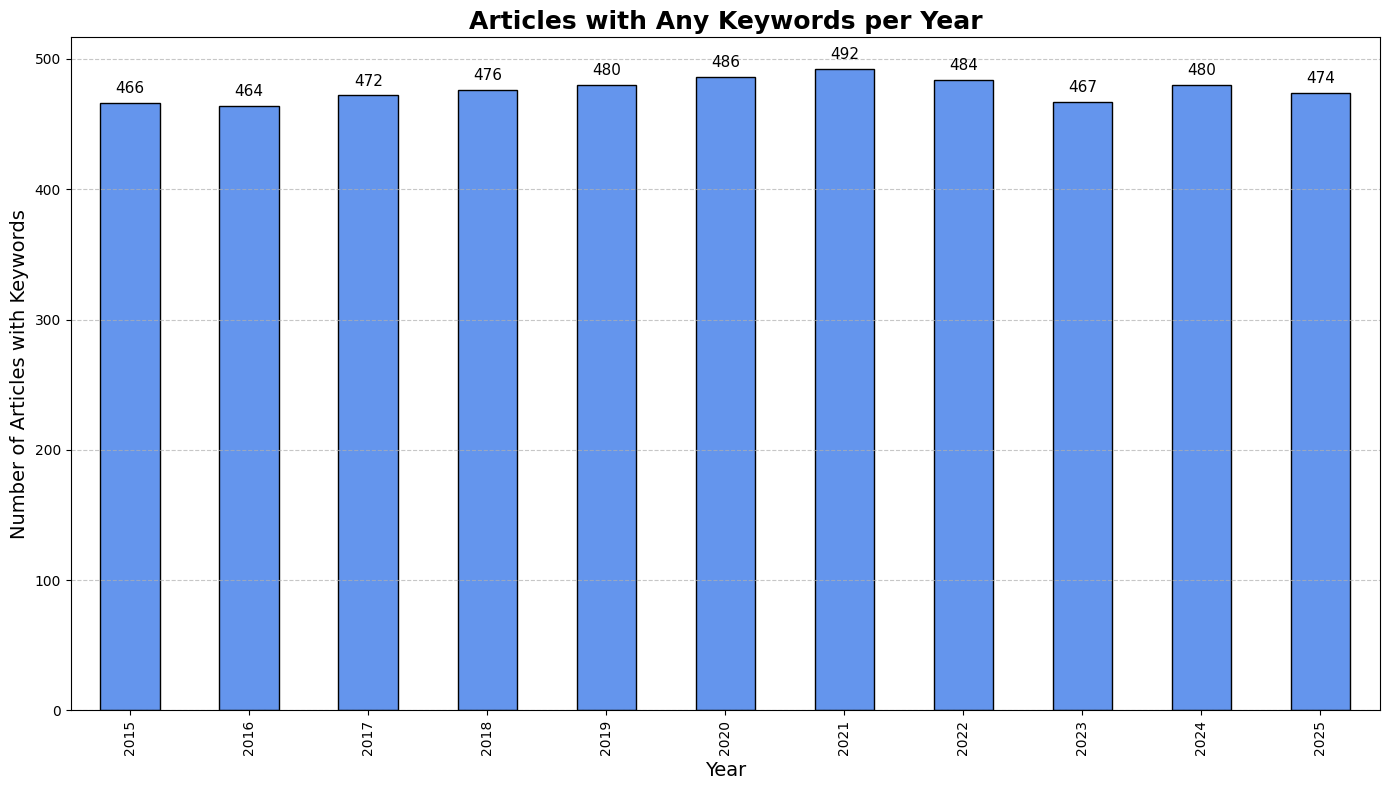

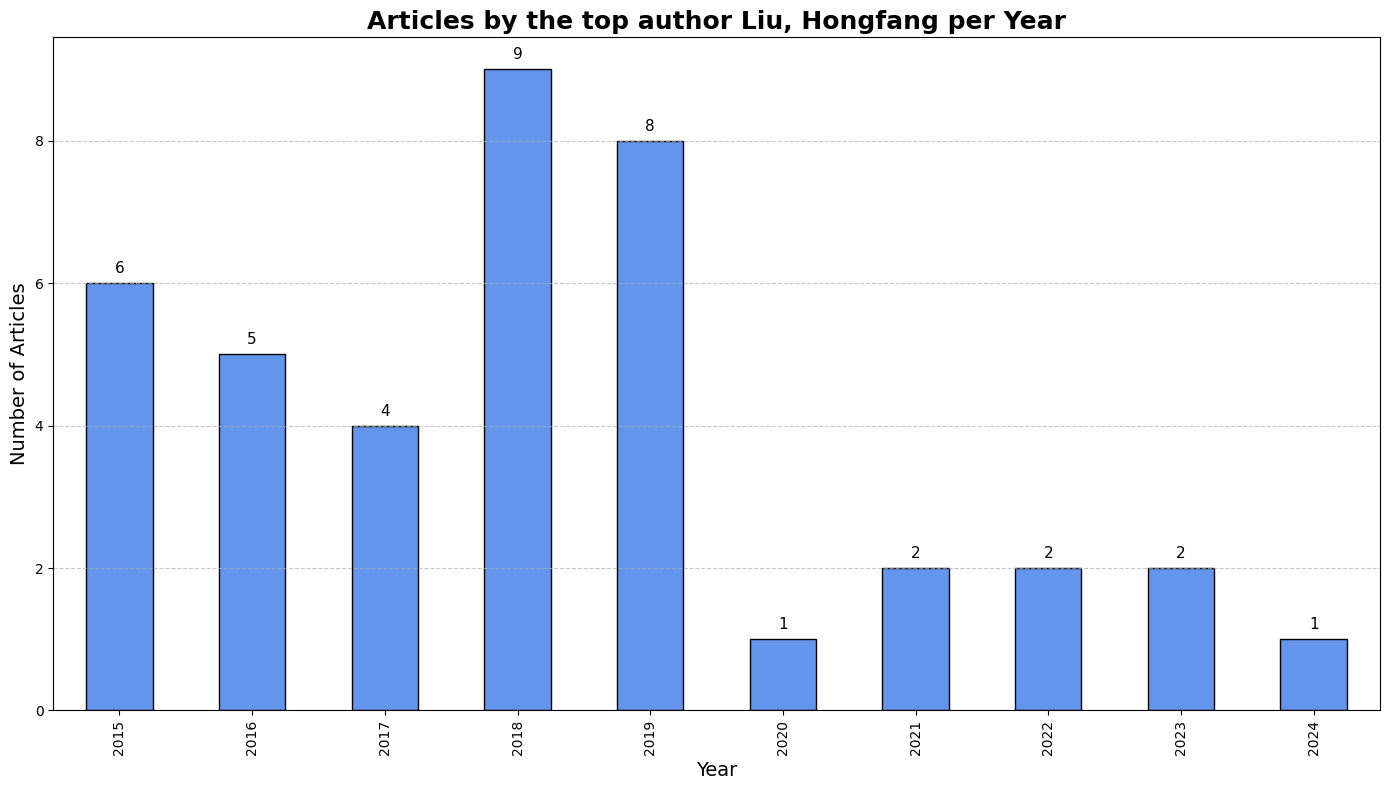

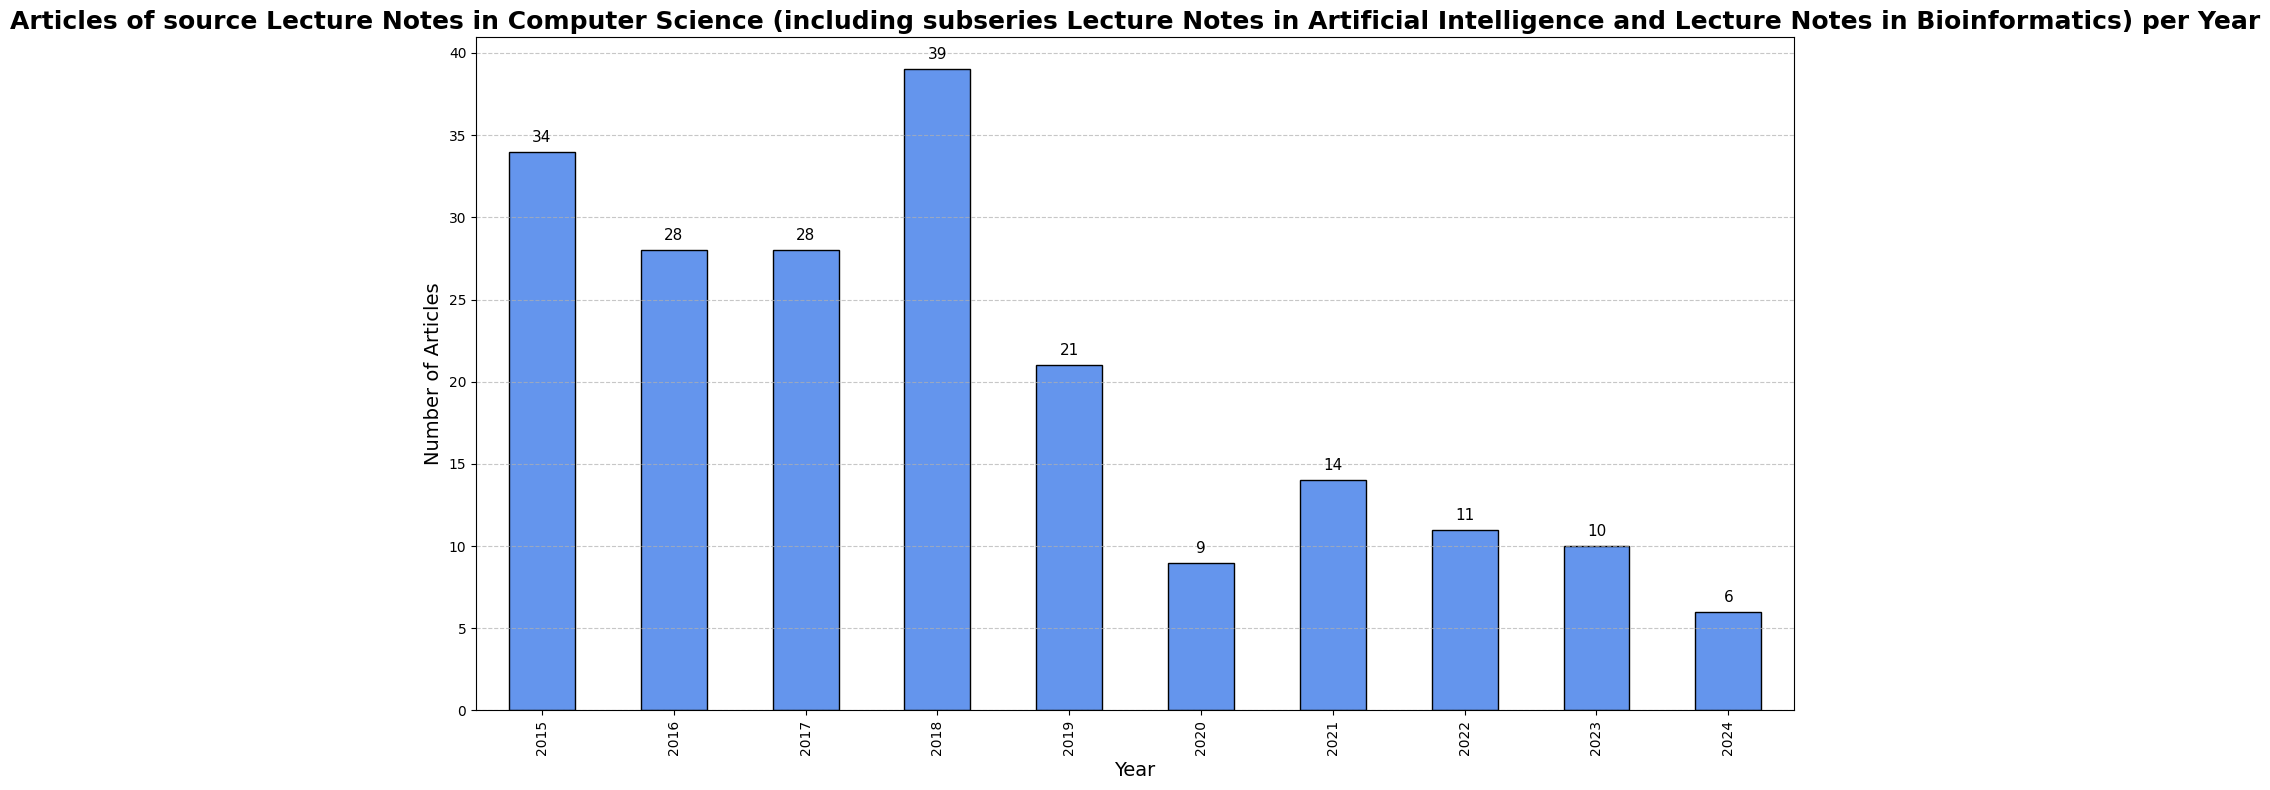

In [ ]:
# show how much articles have keywords in each year
articles_df['Has Any Keywords'] = articles_df['Combined Keywords'].apply(lambda x: len(x) > 0)
articles_per_year_keywords = articles_df.groupby('Year')['Has Any Keywords'].value_counts().unstack().fillna(0)
articles_per_year_keywords = articles_per_year_keywords.sort_index()
create_bar_chart(articles_per_year_keywords[True], "Articles with Any Keywords per Year", "Year", "Number of Articles with Keywords")

# show how many articles were written by the top author in each year
top_author = top_authors.index[0]
top_author_articles = articles_df[articles_df['Author full names'].str.contains(top_author, na=False)]
top_author_per_year = top_author_articles['Year'].value_counts().sort_index()
create_bar_chart(top_author_per_year, f"Articles by the top author {top_author} per Year", "Year", "Number of Articles")

# show how many articles were written by the top source in each year
top_source = top_sources.index[0]
top_source_articles = articles_df[articles_df['Source title'] == top_source]
top_source_per_year = top_source_articles['Year'].value_counts().sort_index()
create_bar_chart(top_source_per_year, f"Articles of Source: {top_source} per Year", "Year", "Number of Articles")

### 9. Showing most present keywords, and trends over the years

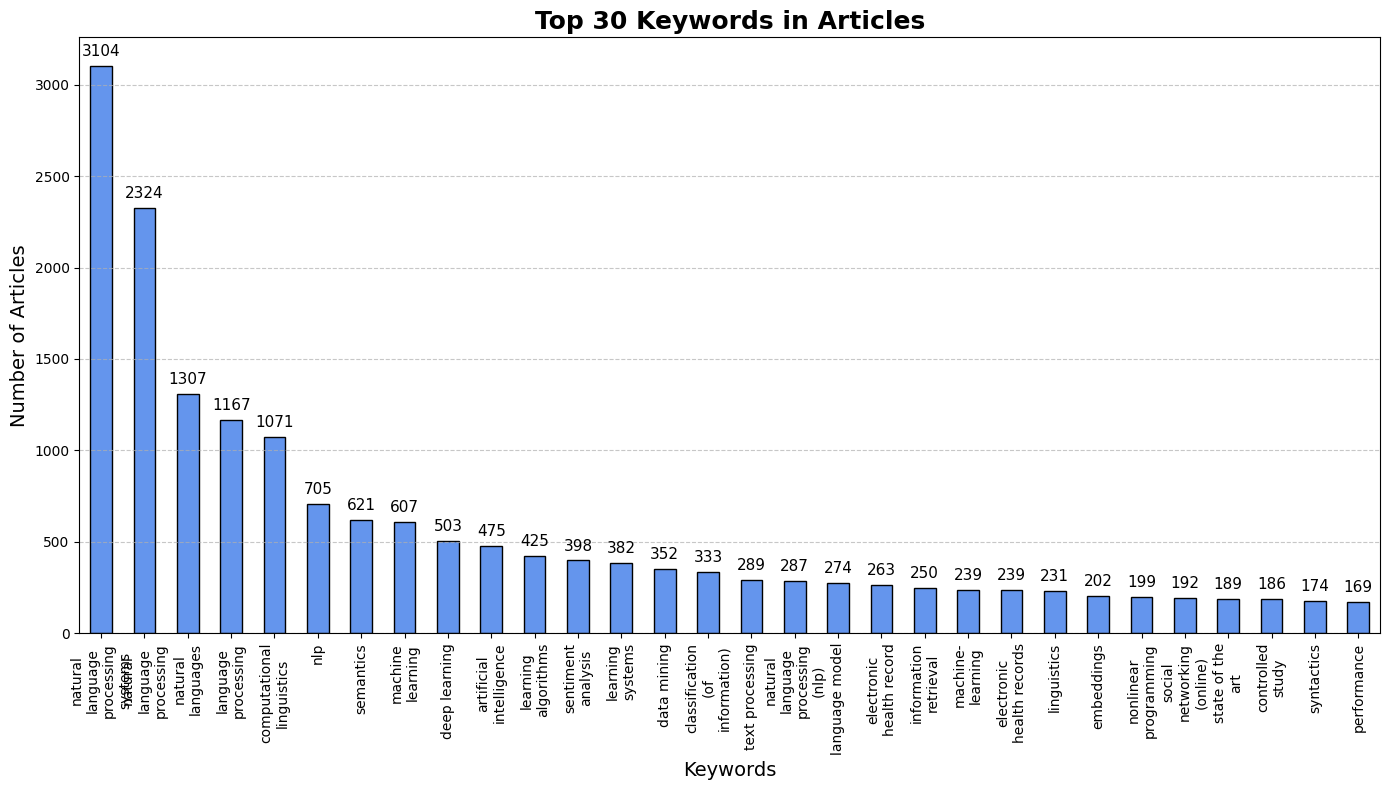

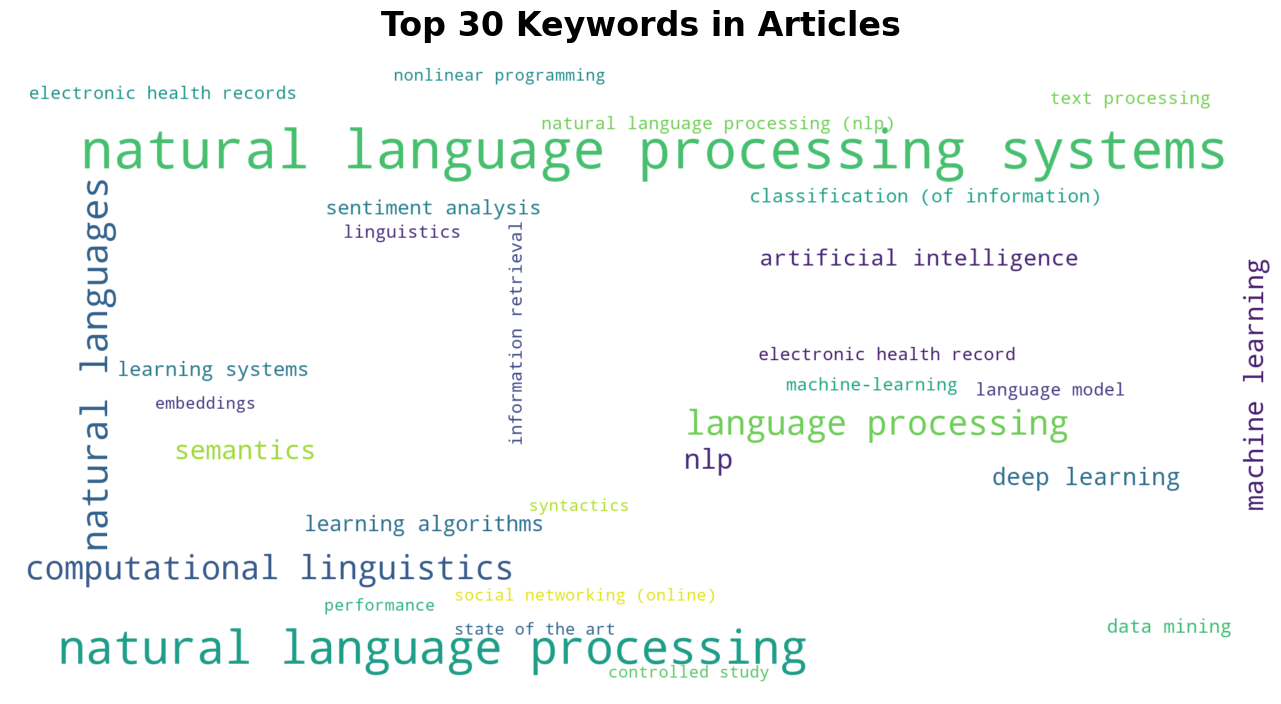

In [ ]:
all_keywords = articles_df['Combined Keywords'].explode().dropna()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")

### Showing the most popular keywords over time(removing some of the first as they are too broad)

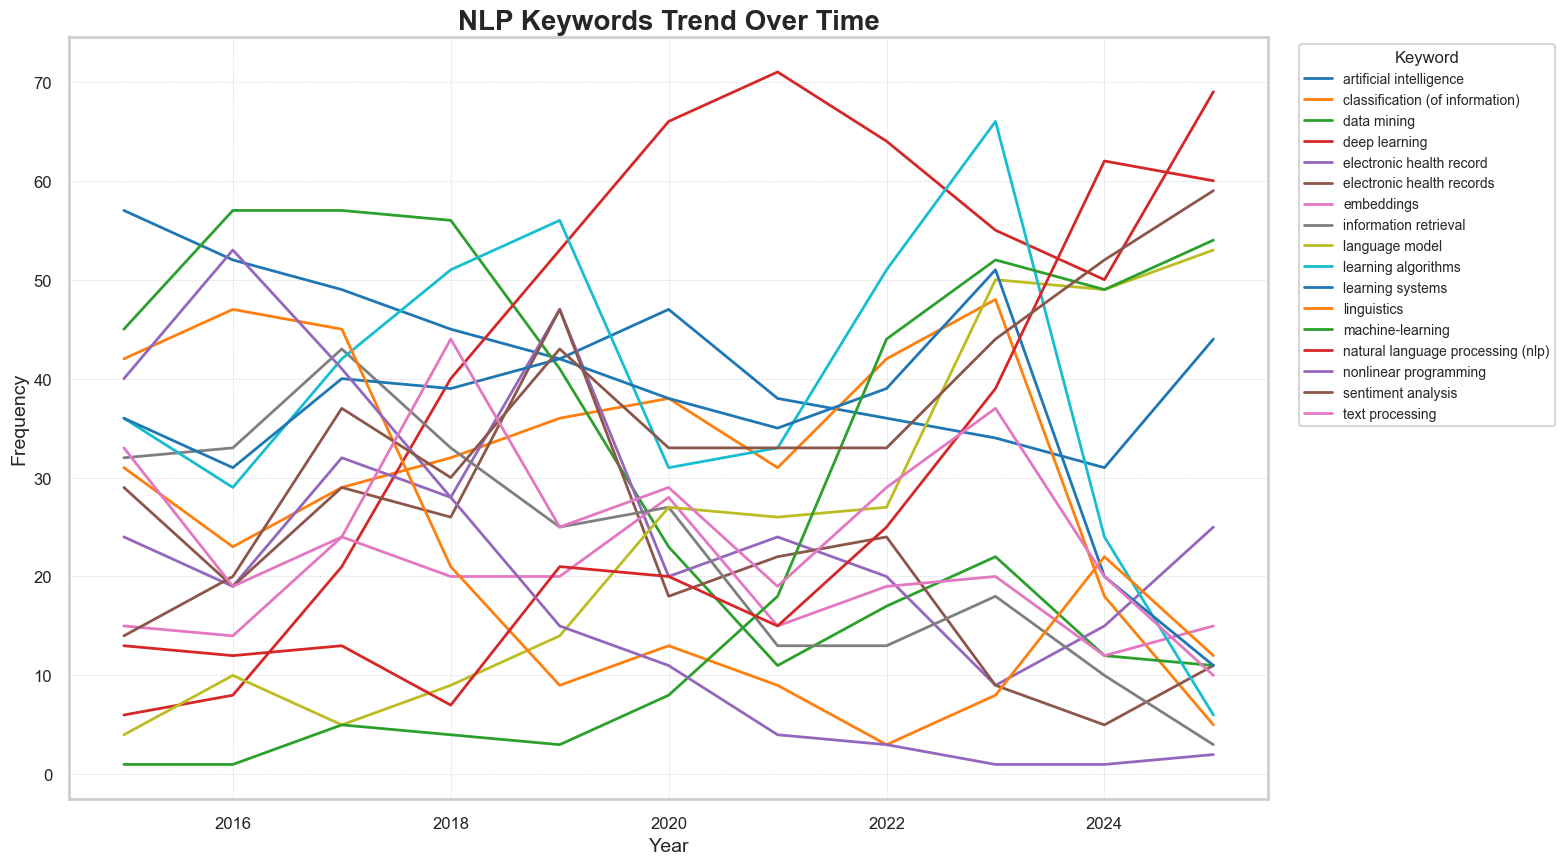

In [115]:
top_keywords = keyword_counts.index.tolist()[8:25]
articles_df['Combined Keywords'] = articles_df['Combined Keywords'].apply(lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else [])
keywords_year_df = articles_df.explode('Combined Keywords')
keywords_year_df = keywords_year_df[keywords_year_df['Combined Keywords'].isin(top_keywords)]
trend_data = (keywords_year_df.groupby(['Year', 'Combined Keywords']).size().unstack(fill_value=0).sort_index())
sns.set_theme(style="whitegrid", context="talk", palette="tab10")
plt.figure(figsize=(16, 9))
for keyword in trend_data.columns:
    plt.plot(trend_data.index, trend_data[keyword], label=keyword, linewidth=2)
plt.title("NLP Keywords Trend Over Time", fontsize=20, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Keyword", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### Showing highly correlated keywords

In [116]:
exploded_keywords_df = articles_df[['Combined Keywords']].explode('Combined Keywords')
exploded_keywords_df['Combined Keywords'] = exploded_keywords_df['Combined Keywords'].str.lower().str.strip()
binary_matrix = pd.crosstab(exploded_keywords_df.index, exploded_keywords_df['Combined Keywords'])
top_keywords = exploded_keywords_df['Combined Keywords'].value_counts().head(1500).index
filtered_matrix = binary_matrix[top_keywords]
correlation_matrix = filtered_matrix.corr(method='pearson')
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)


### Pairs that got a 1 score means that those keywords always appeared together in an article, some obvious ones like "dog" and "dogs" 

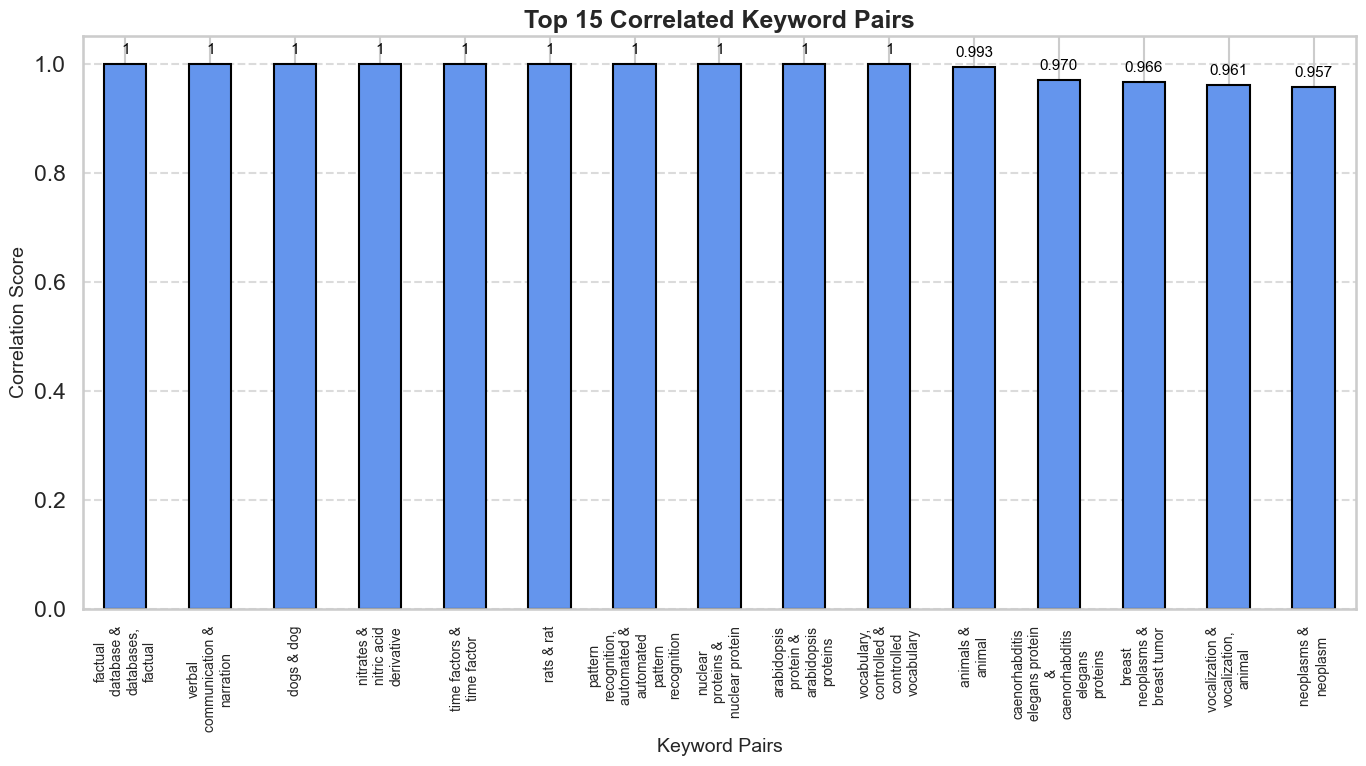

In [117]:
top_correlated_pairs = upper_triangle.stack().sort_values(ascending=False)

top_corr_pairs = top_correlated_pairs.head(15)

pair_labels = [f"{a} & {b}" for a, b in top_corr_pairs.index]
correlation_scores = top_corr_pairs.values

create_bar_chart(pd.Series(correlation_scores, index=pair_labels),
                  "Top 15 Correlated Keyword Pairs",
                    "Keyword Pairs", "Correlation Score")

### Using statistical prominence(z-scores) showing raising or unusually frequent keywords - helps identify each year's trends in NLP research
### Some clear ones are covid-19 raising in 2021-2022, LLMs and chatbots dominating 2025 research

In [118]:
keyword_year_df = articles_df[['Year', 'Combined Keywords']].explode('Combined Keywords')
keyword_year_df = keyword_year_df.dropna()
keyword_counts = keyword_year_df.groupby(['Combined Keywords', 'Year']).size().unstack(fill_value=0)

min_total_count = 30
total_counts = keyword_counts.sum(axis=1)
keyword_counts = keyword_counts[total_counts >= min_total_count]

z_scores = (keyword_counts - keyword_counts.mean(axis=1).values[:, None]) / keyword_counts.std(axis=1).values[:, None]
z_scores = z_scores.fillna(0)

top_z_keywords_per_year = {}
min_year_count = 10
for year in z_scores.columns:
    valid_keywords = keyword_counts[year] >= min_year_count
    filtered_z = z_scores[year][valid_keywords]
    top_keywords = filtered_z.sort_values(ascending=False).head(8)
    top_z_keywords_per_year[year] = top_keywords

keyword_only_dict = {
    year: list(keywords.index) for year, keywords in top_z_keywords_per_year.items()
}

trend_df_keywords = pd.DataFrame.from_dict(keyword_only_dict, orient='index')
trend_df_keywords.columns = [f"Place {i+1}" for i in range(trend_df_keywords.shape[1])]

display(trend_df_keywords)

,Place 1,Place 2,Place 3,Place 4,Place 5,Place 6,Place 7,Place 8
2015,information science,electronic medical record,genetics,classification,computational linguistics,dependency parsing,artificial intelligence,procedures
2016,ontology,optimal control systems,optimization,semantic web,nonlinear programming,knowledge management,nlp tools,linguistics
2017,education,software engineering,intelligent systems,social networking (online),requirements engineering,information retrieval,nlp tools,medical informatics
2018,recurrent neural networks,supervised learning,text processing,speech recognition,health care,long short-term memory,word embedding,reproducibility
2019,diagnostic imaging,gold standard,electronic health record,algorithm,electronic health records,major clinical study,pos tagging,reproducibility of results
2020,question answering,human experiment,embeddings,state of the art,named entity recognition,text mining,machine translations,deep neural networks
2021,large-scales,transfer learning,deep neural networks,covid-19,down-stream,nlp systems,pipelines,students
2022,parts-of-speech tagging,text data,support vector machines,forecasting,text classification,systematic review,covid-19,speech recognition
2023,e-learning,human language,case-studies,digital storage,transformers,performance,learning algorithms,classification (of information)
2024,machine translation,adversarial machine learning,text analysis,language processing techniques,economic and social effects,data handling,network security,contrastive learning


### Showing how the First place of each year is reaching the peak in that year of research  

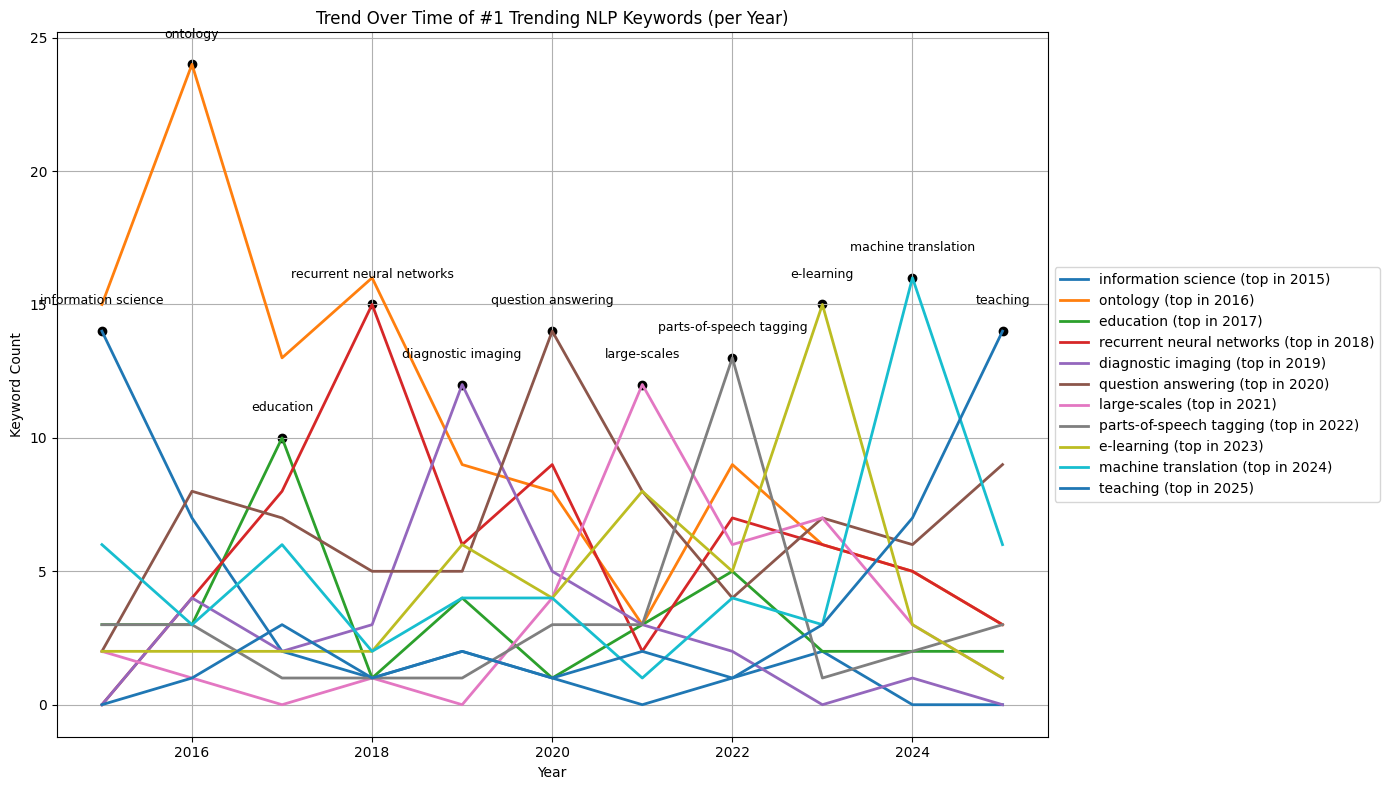

In [ ]:
import matplotlib.pyplot as plt

top_keywords = trend_df_keywords["Place 1"]

plt.figure(figsize=(14, 8))
for year, keyword in top_keywords.items():
    if keyword in keyword_counts.index:
        counts = keyword_counts.loc[keyword]
        plt.plot(
            counts.index, counts.values,
            label=f"{keyword} (top in {year})",
            linewidth=2
        )
        peak_year = counts.idxmax()
        peak_value = counts.max()
        plt.scatter([peak_year], [peak_value], color='black')
        plt.text(peak_year, peak_value + 1, keyword, fontsize=9, ha='center')
plt.xlabel("Year")
plt.ylabel("Keyword Count")
plt.title("Trend Over Time of #1 Trending NLP Keywords (per Year)")
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

### 10. Abstracts summarization - using the t5-small model

In [ ]:
summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    try:
        summary = summarizer("summarize: " + text, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""
SUM_N = 30
summarized_abstracts = [summarize_text(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]


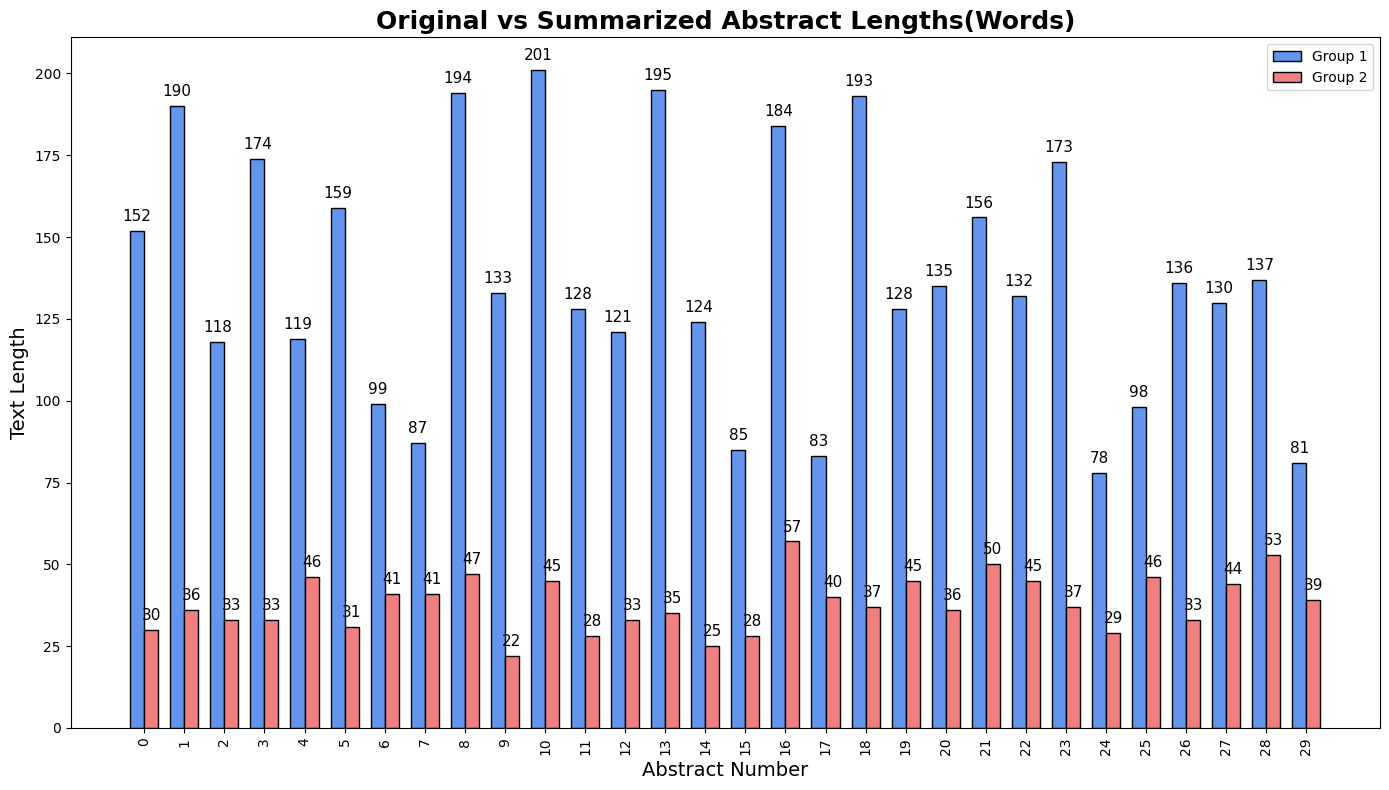

In [ ]:
original_lengths = [len(abstract.split()) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]
summary_lengths = [len(summary.split()) for summary in summarized_abstracts if isinstance(summary, str)]


indices = range(len(original_lengths))

create_grouped_bar_chart(indices, original_lengths, summary_lengths,
                          "Original vs Summarized Abstract Lengths(Words)",
                            "Abstract Number", "Text Length")

### 11. To get GPT to analyze each year's trends, I have picked 10 articles from each year - that contain the most trending keywords of that year - and thus represent it the most.
### Than summarized each of their abstracts, concat them, and let GPT get the keywords from them 

In [ ]:
top_articles_by_keyword = {}

def count_matches(article_keywords):
    return sum(kw in article_keywords for kw in trending_keywords)
for year in trend_df_keywords.index:
    if year not in articles_df['Year'].unique():
        continue
    trending_keywords = trend_df_keywords.loc[year].dropna().str.lower().tolist()
    year_articles = articles_df[articles_df['Year'] == year].copy()
    year_articles = year_articles.dropna(subset=["Combined Keywords"])
    year_articles["Combined Keywords"] = year_articles["Combined Keywords"].apply(lambda kws: [kw.lower() for kw in kws if isinstance(kw, str)])
    year_articles["match_score"] = year_articles["Combined Keywords"].apply(count_matches)
    top_matched = year_articles.sort_values("match_score", ascending=False).head(10)
    top_articles_by_keyword[year] = top_matched

                                                  Title  match_score
2224  Risk factor detection for heart disease by app...            4
2126  Clinical text analysis using interactive natur...            3
2007  NLP based congestive heart failure case findin...            3
2019  Identification of Patients with Family History...            3
2455  MEANS: A medical question-answering system com...            3
2230  Adapting existing natural language processing ...            3
2247  Functional evaluation of out-of-the-box text-m...            3
2121  Using natural language processing to identify ...            3
2205  Identifying Patients with Depression Using Fre...            3
2277  A hybrid model for automatic identification of...            3
                                                  Title  match_score
2894  A two-phase approach for building vietnamesewo...            3
2637  A hybrid DE-SQP method for vertical trajectory...            3
2560  NLP and ontology based clust

In [120]:
summarized_per_year = {}
for year, top_df in top_articles_by_keyword.items():
    article_abstracts = top_df["Abstract"].dropna().astype(str).tolist()
    article_summaries = [summarize_text(abstract) for abstract in article_abstracts]
    final_summary = "\n".join(article_summaries)
    summarized_per_year[year] = final_summary
    print(f"{year}:\n{final_summary}\n")


2015:
the annual cost of care services, medications, and lost productivity reportedly exceeds 108.9 billion dollars . effective disease risk assessment is critical to prevention, care, and treatment planning .
current systems do not provide provisions for incorporating feedback . the aim of this research is to close this gap by building highly-usable tools suitable for the analysis of free text reports .
an effective CHF case finding algorithm is required to process both structured and unstructured electronic medical records (EMR) to allow complementary and cost-efficient identification of CHF patients . the algorithm was retrospectively developed with a random subset of HIE associated facilities, and blind-tested with the remaining facilities .
the family history identification precision was consistent across the institutions shifting from 88.9% on Indiana University dataset to 87.8% on Mayo Clinic dataset . the family member relation discovery achieved precision, recall, and F-measur

### The keywords extracted varies in quality and not deterministic, often hallucinated. Most of the times it does recognize the presence of NLP, AI and some other fields researched with NLP over the years

In [140]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()

def extract_topics_with_gpt(prompt_text,max_new_tokens=50):
    inputs = tokenizer.encode(prompt_text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.9,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

summarized_topics_per_year = {}
for year, combined in summarized_per_year.items():
    prompt = f"What are the main research topics discussed in the following abstracts?\n\n{combined}\n\nTopics:"
    gpt_output = extract_topics_with_gpt(prompt)
    if "Topics:" in gpt_output:
        gpt_output = gpt_output.split("Topics:")[-1].strip()
    summarized_topics_per_year[year] = gpt_output
    print(f"{year}:\n{gpt_output}")


2015:
research, health-and-technology, research-and-technology, australia, australia
First posted
2016:
[1] Theoretical Physics, A. W. D. D. and B. A. A. A. D. H.
[2] Theoretical Physics, A. W. D. D. and B.
2017:
health, social, and medical, natural-language, machine learning, social-network, human-mind, medical-science, public-health, human-science, social-network-social-networking, human-mind, medical-science
2018:
English, Arabic, French, Turkish, Indonesian, Middle Eastern, New Zealand, Russian Federation, U.S. Government
2019:
clinical, orthopedic, surgical
2020:
NLP
2021:
nlp, computer, human, artificial intelligence, human
2022:
public-interest, human-interest, human-interest, international-security, human-interest, the-underground, human-interest, law-crime-and-justice, human-interest, australia, nt
2023:
scientific, engineering, community, science-and-technology, public-sector, science-and-technology, technology-and-technology, public-policy, human-interest, business-economics

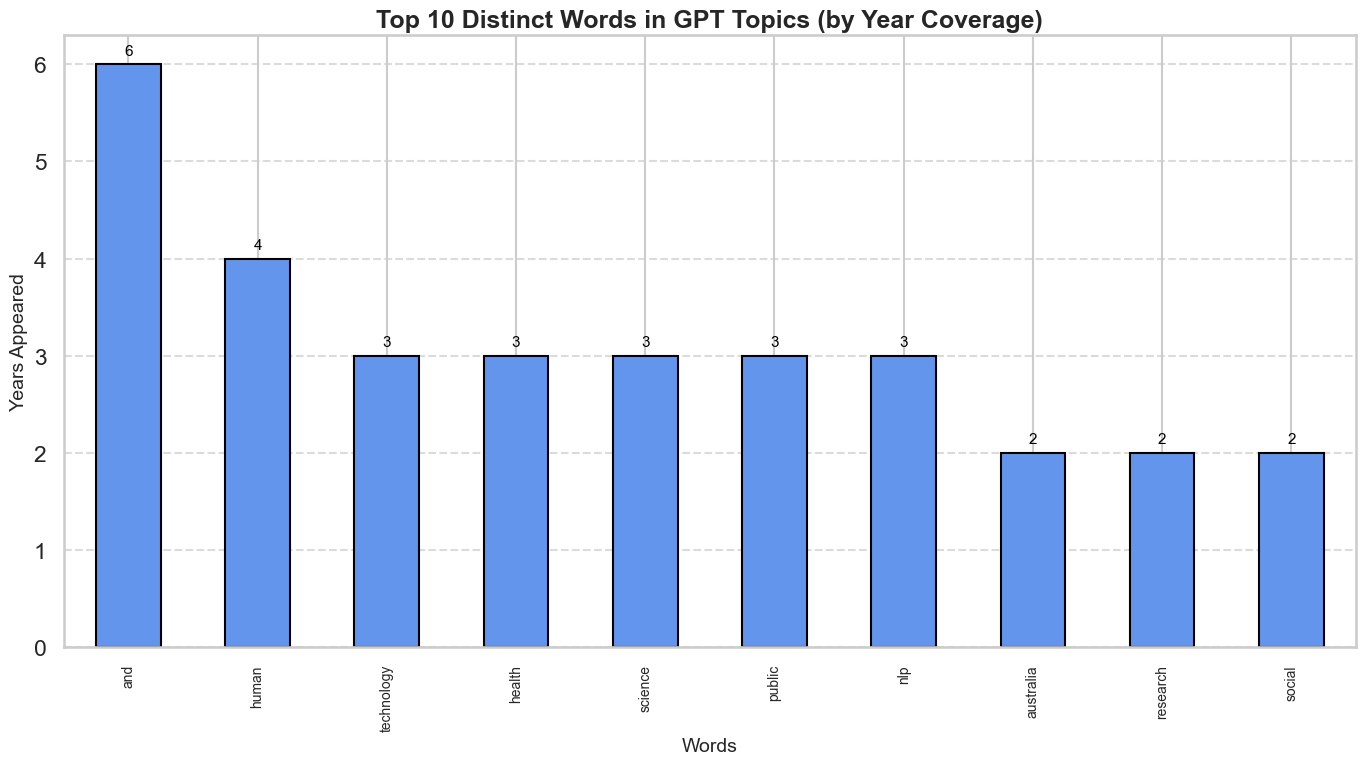

In [144]:
unique_words_per_year = []
for year, text in summarized_topics_per_year.items():
    tokens = re.findall(r'\b\w+\b', text.lower())
    cleaned_tokens = {token for token in tokens if len(token) > 1 and not token.isnumeric()}
    unique_words_per_year.extend(cleaned_tokens)
word_freq = Counter(unique_words_per_year)
top_words = word_freq.most_common(10)
top_words_series = pd.Series(dict(top_words))
create_bar_chart(top_words_series,"Top 10 Distinct Words in GPT Topics (by Year Coverage)","Words","Years Appeared")


### 12. It is clear that using EDA methods on the data in 9 let to better trends and keywords analysis than using Question-Answering GPT2 with samples of article summarizations, due to limited resources couldn't use a more powerful GPT model, which may improve significantly the results    